# VIP - Vortex Image Processing package

For VIP *v1.0.0* onwards

Written by: *Carlos Alberto Gomez Gonzalez*. New additions and updates for v1.0.0 by *Valentin Christiaens*.

Last update: *2021/09/22*

## Table of contents

* [1. Loading ADI data](#1.-Loading-ADI-data)

* [2. Pre-processing the ADI cube](#2.-Pre-processing-the-ADI-cube)

* [3. Generating synthetic planets](#3.-Generating-synthetic-planets)
 
* [4. **Flux and position estimation with NEGFC**](#4.-Flux-and-position-estimation-with-NEGFC)
    - [4.1. **Nelder-Mead based optimization**](#4.1.-Nelder-Mead-based-optimization)
    - [4.2. Planet subtraction](#4.2.-Planet-subtraction)
    - [4.3. **NEGFC technique coupled with MCMC**](#4.3.-NEGFC-technique-coupled-with-MCMC)
        - [4.3.1. Running the MCMC sampler](#4.3.1.-Running-the-MCMC-sampler)
        - [4.3.2. Visualizing the MCMC chain: corner plots and walk plots](#4.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [**4.3.3. Highly probable values and confidence intervals**](#4.3.3.-Highly-probable-values-and-confidence-intervals)
    - [**4.4. Residual speckle uncertainty**](#4.4.-Residual-speckle-uncertainty)
    - [**4.5. Final uncertainties**](#4.5.-Final-uncertainties)
    
* [5. **Throughput and contrast curve**](#5.-Throughput-and-contrast-curve)
    - [5.1. **Algorithmic throughput**](#5.1.-Algorithmic-throughput)
    - [5.2. **Contrast curve generation for ADI**](#5.2.-Contrast-curve-generation-for-ADI)


*Bold face corresponds to either new additions or significant updates compared to the version of the notebook made for VIP v0.9.11

-----------

Let's assume ``VIP`` and ``HCIplot`` are properly installed. We import the packages along with other useful libraries:

In [1]:
%matplotlib inline
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np

import vip_hci as vip
from hciplot import plot_frames, plot_cubes

Parts of the notebook will only run if ``opencv`` is installed (recommended albeit optional dependency of VIP) or for versions above 1.0.0. We will set `if` switches and a version parser to avoid any bug: 

In [2]:
from packaging import version
vvip = vip.__version__
vvip

'1.0.0'

The ``HCIplot`` package aims to be the "Swiss army" solution for plotting and visualizing multi-dimensional high-contrast imaging datacubes. It replaces the `vip_hci.var.pp_subplots` function present in older version of ``VIP``. `VIP` also allows interactive work with `DS9` provided that it's installed on your system along with ``pyds9``. A `DS9` session (window) can be started with: 

```ds9 = vip.Ds9Window()```

If the above fails but you have pyds9 installed (``vip_ds9`` is only a wrapper around ``pyds9``), you may find the [following troubleshooting tips](https://community.lsst.org/t/ds9-communication-via-xpa/2242) useful (e.g. step 4 in particular).

Then the *ds9* methods will allow interaction with the `DS9` window. For example, for sending an in-memory array to the `DS9` window you can simply use:

```ds9.display(2d_or_3d_array)```

The above can be used instead of ```HCIplot```'s ```plot_frames``` and ```plot_cubes``` routines (the latter being used in this notebook) for visualization and interaction with your images/datacubes.

# 1. Loading ADI data

[identical to notebook 01]

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO coronagraphic (VORTEX AGPM) dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract). The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

**IMPORTANT** - VIP's convention is to work with input frames and cubes with an **odd** number of pixels along the x and y directions. Centering of the star then places its centroid on the central pixel. Currently the only VIP module that does not follow this convention is the ```andromeda``` module, which assumes input datacubes with an *even* number of pixels (with the star centered between the 4 central pixels).

Let's inspect the fits file:

In [3]:
vip.fits.info_fits('../datasets/naco_betapic_cube.fits')

Filename: ../datasets/naco_betapic_cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (101, 101, 61)   float32   


The fits file contains an ADI datacube of 61 images 101x101 px across. ADI sequences are acquired in pupil tracking mode, which means that the instrument field derotator remains off during the observation, thereby keeping the instrument and telescope optics aligned while the field of view rotates with time. The orientation of north in the images is given by so-called parallactic angles, which are varying throughout an ADI sequence. 
The parallactic angle vector for this observation is saved in the `naco_betapic_pa.fits` file. 

<font color=orange> **Question 1.1:** When observing a celestial object with a given telecope, what 3 parameters do the values of parallactic angle depend on? </font>

**Note**: throughout this notebook, questions will be raised in <font color=orange>orange</font>. Corresponding answers will be provided in <font color=green>green</font> at the end of the respective (sub)sections.

Now we load the data "in" memory with the `open_fits` function:

In [4]:
psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube_orig = vip.fits.open_fits(cubename)
psf = vip.fits.open_fits(psfnaco)
pa = vip.fits.open_fits(angname)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)
Fits HDU-0 data successfully loaded. Data shape: (61,)


`open_fits` is a wrapper of the `astropy` fits functionality. The fits file is now a ndarray or ``numpy`` array in memory.

**Tip**: more information on any python object can be obtained by appending `?`. E.g. run ```vip.fits.open_fits?``` for more information about the ```open_fits``` routine and its optional arguments.

If you open the datacube with ds9 (or send it to the `DS9` window) and adjust the cuts you will see the beta Pic b planet moving on a circular trajectory, among similarly bright but quasi-static speckle. Alternatively, you can use `hciplot.plot_cubes`:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

For instance, instead of opts('Points (size=5)', points) use points.opts(opts.Points(size=5))


:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 61]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
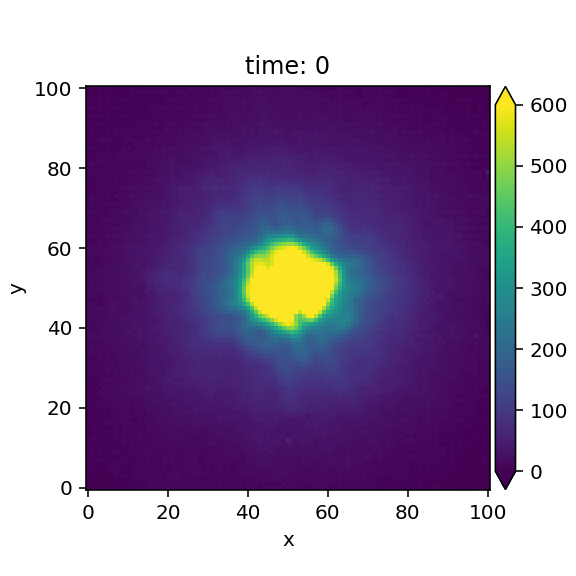

In [5]:
plot_cubes(cube_orig, vmin=0, vmax=600)

Note that the parallactic angles are not the final derotation angles to be applied to the images to match north up and east left (i.e. the standard convention for astronomical images). The final derotation angles are obtained by also adding the derotator offset (set at the beginning of the observation) and the true north angle (specific to the instrument and obtained here from a dedicated astrometric calibration of NACO). The values we adopt are taken from Absil et al. (2013).

In [6]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa+derot_off+TN

Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

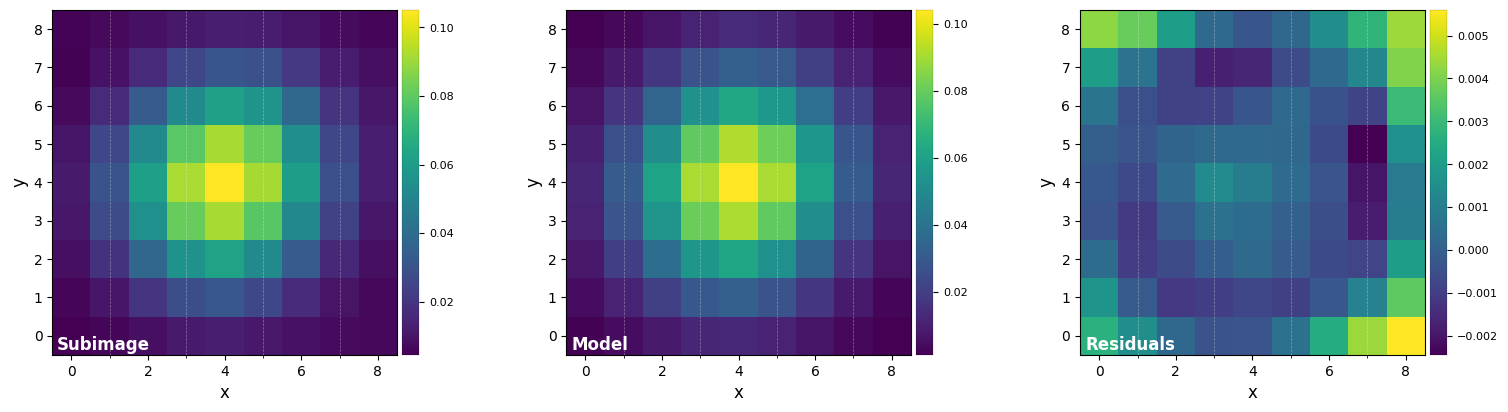

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [7]:
%matplotlib inline
DF_fit = vip.var.fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [8]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [9]:
psfn = vip.metrics.normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


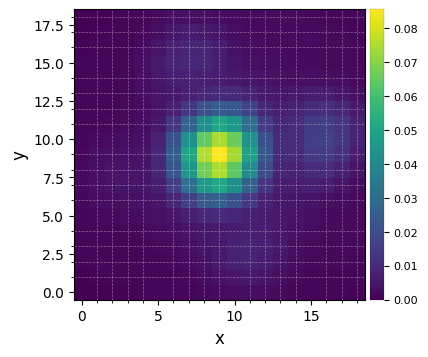

In [10]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `conf` subpackage:

In [11]:
pxscale_naco = vip.conf.VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


[Go to the top](#Table-of-contents)

# 2. Pre-processing the ADI cube

[see full section in notebook 01]

In [12]:
from vip_hci.preproc import cube_recenter_2dfit, cube_recenter_dft_upsampling, cube_shift

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-24 22:18:12
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The first frame is assumed to be well centered wrt thecenter of the array
The rest of the frames will be shifted by cross-correlation wrt the 1st
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.651532
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Shifts required to align the frames of the cube with respect to the first one:


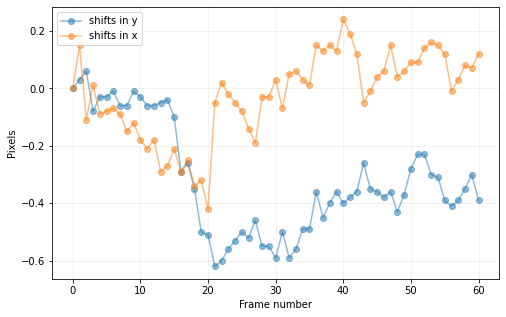

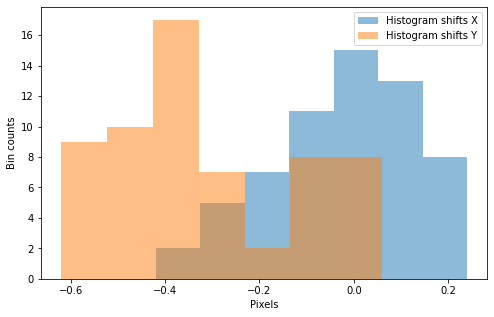

In [13]:
cube_align, shy2a, shx2a = cube_recenter_dft_upsampling(cube_orig, center_fr1=(51, 51), 
                                                        fwhm=fwhm_naco, #subi_size=5, negative=True,
                                                        full_output=True, debug=False, imlib='ndimage-fourier')
cube_al_mean = np.mean(cube_align,axis=0)
print("Shifts required to align the frames of the cube with respect to the first one:")
plt.show()

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-24 22:18:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.024909
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Final shift to place the star at the center of the images:


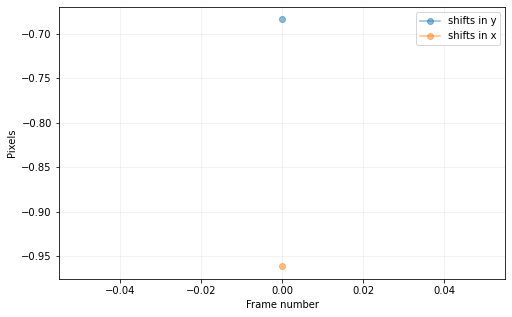

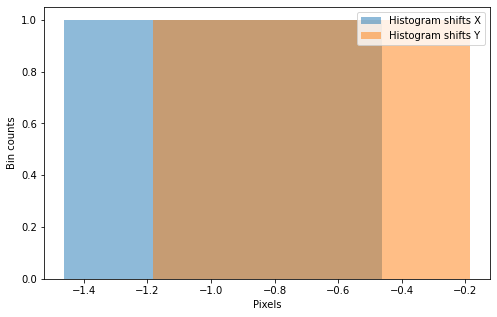

Combined shifts:


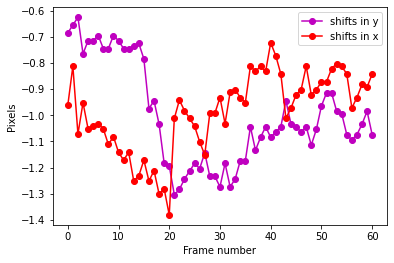

In [14]:
_, shy2b, shx2b = cube_recenter_2dfit(cube_al_mean[np.newaxis,:,:], xy=(51, 51), fwhm=fwhm_naco, 
                                      nproc=1, subi_size=5, model='gauss', negative=True, 
                                      full_output=True, debug=False, imlib='ndimage-fourier')
print("Final shift to place the star at the center of the images:")
plt.show()
cube2 = cube_shift(cube_align, shy2b[0], shx2b[0], imlib='ndimage-fourier')
shy2 = shy2a+shy2b[0]
shx2 = shx2a+shx2b[0]

print("Combined shifts:")
plt.plot(range(cube_orig.shape[0]),shy2,'mo-', label='shifts in y')
plt.plot(range(cube_orig.shape[0]),shx2,'ro-', label='shifts in x')
plt.xlabel("Frame number")
plt.ylabel("Pixels")
plt.legend()
plt.show()

In [15]:
cube = cube2

[Go to the top](#Table-of-contents)

# 3. Generating synthetic planets

Select `imlib` depending on VIP version:

In [16]:
# For versions >= 1.0.0, use Fourier-transform based method
if version.parse(vvip) >= version.parse("1.0.0"):
    imlib_rot = 'vip-fft'
    interpolation=None
else:
    imlib_rot = 'skimage'
    interpolation = 'biquartic'    

With `VIP` we can inject fake companions at arbitrary fluxes and locations, using the normalized PSF. Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection are provided in the *derotated* image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [17]:
from vip_hci.metrics import cube_inject_companions

In [18]:
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=400, plsc=pxscale_naco, 
                                rad_dists=[30.5], theta=240, n_branches=1, imlib=imlib_rot)

Branch 1:
	(X,Y)=(34.75, 23.59) at 0.83 arcsec (30.50 pxs from center)


Let's set the corresponding cartesian coordinates:

In [19]:
xy_test = (35,24)

Let's infer the optimal $n_{\rm pc}$ for PCA in a single annulus - this will be useful for NEGFC ([Section 8](#8.-Flux-and-position-estimation-with-NEGFC)). Note that the `pca_grid` function is the same as used internally by `vip.pca.pca` when `source_xy` is set and a tuple provided for `ncomp`.  The advantage of using it directly is that it returns the value of the optimal $n_{\rm pc}$.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-24 22:18:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.027707
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 10, for S/N=11.828
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 35.0, 24.0
Flux in a centered 1xFWHM circular aperture = 101.613
Central pixel S/N = 16.926
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 11.828
Max S/N (shifting the aperture center) = 17.376
stddev S/N (shifting the aperture center) = 4.063



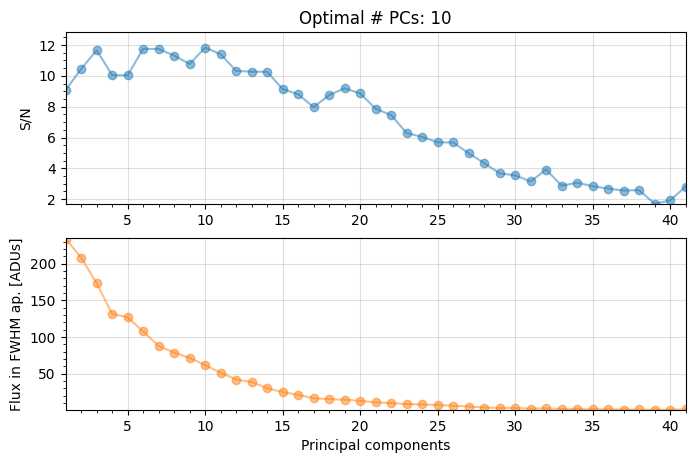

In [20]:
from vip_hci.pca import pca_grid

res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

In [21]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

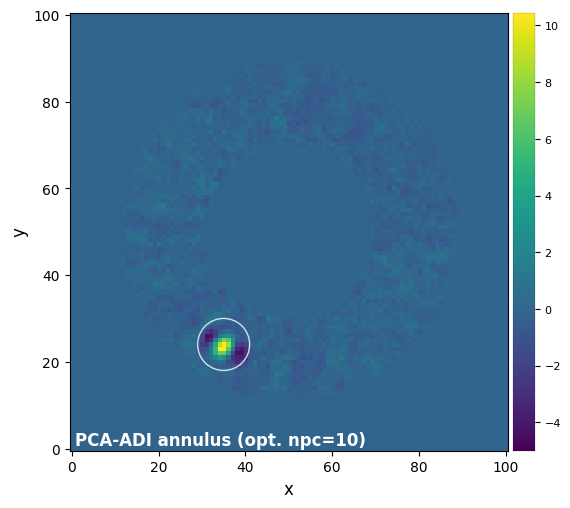

In [22]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

Note that the optimal number of PCs found for the injected fake companion is different to that found for Beta Pic b (10 vs 7; [Sec. 5.6](#5.6.-PCA-in-a-single-annulus)). This is because different $n_{\rm pc}$ values lead to a different trade-off between speckle modeling and self-subtraction/overfitting at different radii - the width of the annulus was also changed between the 2 tests. The radial dependency of optimal $n_{\rm pc}$ is a result also found in Meshkat et al. (2014).

[Go to the top](#Table-of-contents)

# 4. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). <font color=orange> **Question 4.1**: Why would a simple 2D Gaussian fit (as performed for the stellar PSF in Section 1) lead to biased results for the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only (provided a fixed estimate of the position) - in `vip.negfc.firstguess`;

B) a Nelder-Mead simplex algorithm - in `vip.negfc.firstguess`;

C) an MCMC sampler (which has the advantage to also yield uncertainties on each of the parameters of the point source) - in `vip.negfc.mcmc_negfc_sampling`.

The following default figure of merit is used for minimization (Wertz et al. 2017):
$$\chi^2 = \sum_j |I_j|,$$
where $j \in {1,...,N}$ and $N$ the total number of pixels contained in the circular aperture around the companion candidate.

The FFT-based rotation method will be too slow for the NEGFC algorithm (at least if you are running this notebook on a laptop), we therefore adapt ``imlib`` and ``interpolation`` to less accurate but faster methods:

In [23]:
# For versions >= 1.0.0, use Fourier-transform based method
try:
    import opencv
    imlib_rot = 'opencv'
    interpolation= 'lanczos4'
    nocv2 = False
except:
    imlib_rot = 'skimage'
    interpolation = 'biquartic'   
    nocv2 = True

[Go to the top](#Table-of-contents)

## 4.1. Nelder-Mead based optimization

With the function `vip.negfc.firstguess` we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

In [24]:
from vip_hci.negfc import firstguess

Fisrt we define the position of the sources by examining a flux frame or S/N map. `source_xy` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the (approximate) coordinates of the previously injected companion. Also, let's set the # of PCs to 30, which is higher than the optimal value (for full-frame PCA) and leads to a more aggresive reduction:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-24 22:20:35
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [35,24], running ...
Step | flux    | chi2r
1/100   0.000   546.807
2/100   50.505   488.946
3/100   101.010   425.469
4/100   151.515   365.470
5/100   202.020   303.476
6/100   252.525   254.013
7/100   303.030   213.771
8/100   353.535   191.201
9/100   404.040   190.408
10/100   454.545   216.159
11/100   505.051   261.637
12/100   555.556   315.214


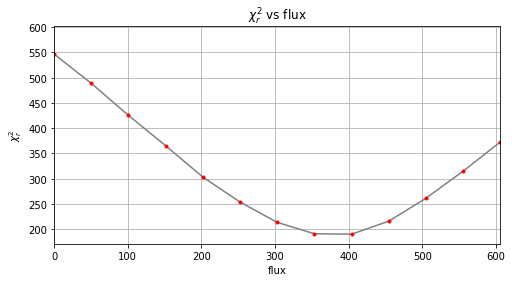

Planet 0: preliminary guess: (r, theta, f)=(30.0, 240.0, 404.0)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 109, nfev: 233, chi2r: 115.27835083007812
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.493, 239.990, 385.408) at 
          (X,Y)=(34.75, 23.60)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:01:54.426497
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [25]:
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, plsc=pxscale_naco,
                                  planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                                  f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                                  simplex=True, imlib=imlib_rot, interpolation=interpolation,
                                  plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-24 22:22:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [35,24], running ...
Step | flux    | chi2r
1/100   0.000   70.860
2/100   50.505   67.508
3/100   101.010   64.866
4/100   151.515   62.038
5/100   202.020   56.997
6/100   252.525   51.693
7/100   303.030   45.605
8/100   353.535   40.221
9/100   404.040   37.379
10/100   454.545   38.842
11/100   505.051   42.745
12/100   555.556   47.599


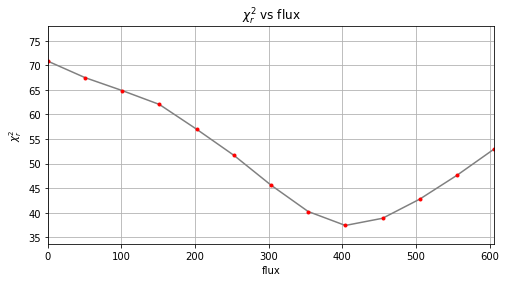

Planet 0: preliminary guess: (r, theta, f)=(30.0, 240.0, 404.0)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 110, nfev: 259, chi2r: 33.81623077392578
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.285, 240.009, 428.273) at 
          (X,Y)=(34.86, 23.77)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:01:55.967426
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [26]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, plsc=pxscale_naco,
                                  planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                                  f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                                  imlib=imlib_rot, interpolation=interpolation, simplex=True, 
                                  plot=True, verbose=True)

The Nelder-Mead optimization found close-to-optimal minima. For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the estimated parameters are unfortunately not equal to the original values (radius=30.5, theta=240, flux=400), which reflects:
- the limitations of this heuristic minization procedure (depending on the initial guess the minimization can get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.
These are parameter estimates without uncertainties (error bars). We will come back to this question later on. 

It is worth noting that on the other hand using the optimal $n_{\rm pc} = 10$ found in [Section 5.6](#5.6.-PCA-in-a-singla-annulus) leads to a much closer estimate to the ground truth:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-24 22:24:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [35,24], running ...
Step | flux    | chi2r
1/100   0.000   302.005
2/100   50.505   272.741
3/100   101.010   245.482
4/100   151.515   214.850
5/100   202.020   185.589
6/100   252.525   157.360
7/100   303.030   131.858
8/100   353.535   113.073
9/100   404.040   108.209
10/100   454.545   118.000
11/100   505.051   141.970
12/100   555.556   170.413


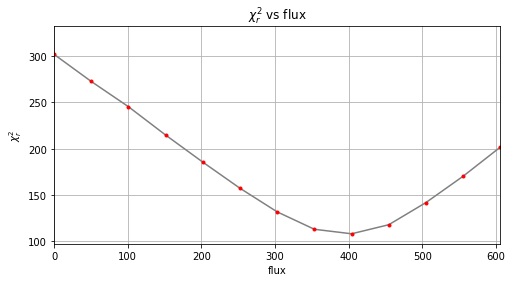

Planet 0: preliminary guess: (r, theta, f)=(30.0, 240.0, 404.0)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 124, nfev: 257, chi2r: 70.3759765625
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.467, 239.851, 395.531) at 
          (X,Y)=(34.70, 23.65)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:01:55.370595
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [27]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, plsc=pxscale_naco,
                               planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                               f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                               imlib=imlib_rot, interpolation=interpolation, simplex=True, 
                               plot=True, verbose=True)

<font color=green> **Answer 4.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

[Go to the top](#Table-of-contents)

## 4.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `vip.negfc.cube_planet_free`.

In [1]:
from vip_hci.negfc import cube_planet_free

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [29]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

Note: r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in (i.e the length of) `plpar_fc` should match the number of planets.

In [30]:
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)

In [31]:
fr_pca_emp = vip.pca.pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                                 r_guess=30.5, imlib=imlib_rot, interpolation=interpolation)

Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [32]:
cropped_frame1 = vip.preproc.frame_crop(final_ann_opt, cenxy=xy_test, size=15)

New shape: (15, 15)


In [33]:
cropped_frame2 = vip.preproc.frame_crop(fr_pca_emp, cenxy=xy_test, size=15)

New shape: (15, 15)


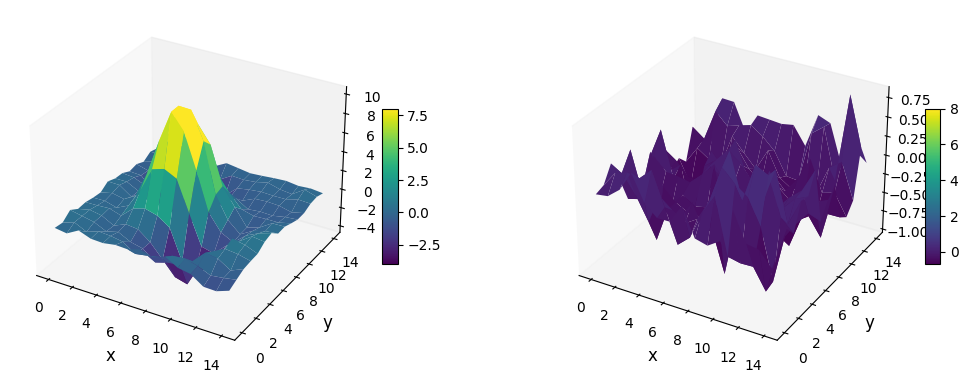

In [34]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

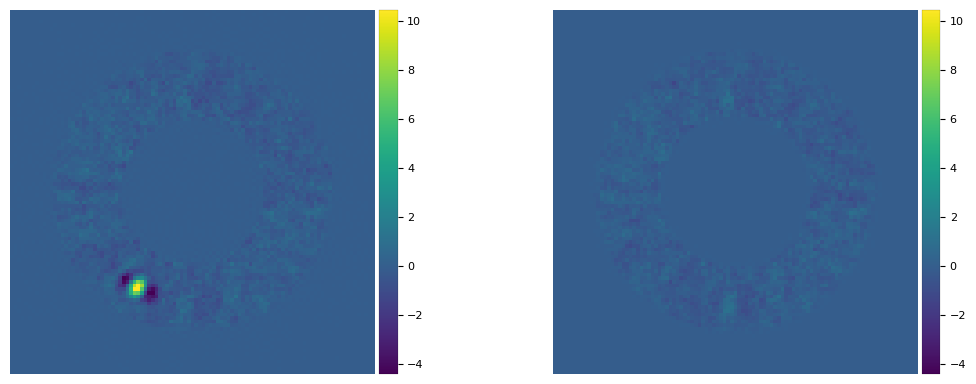

In [35]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

[(30.493050635619337, 239.9895644677281, 385.40773675685205)]


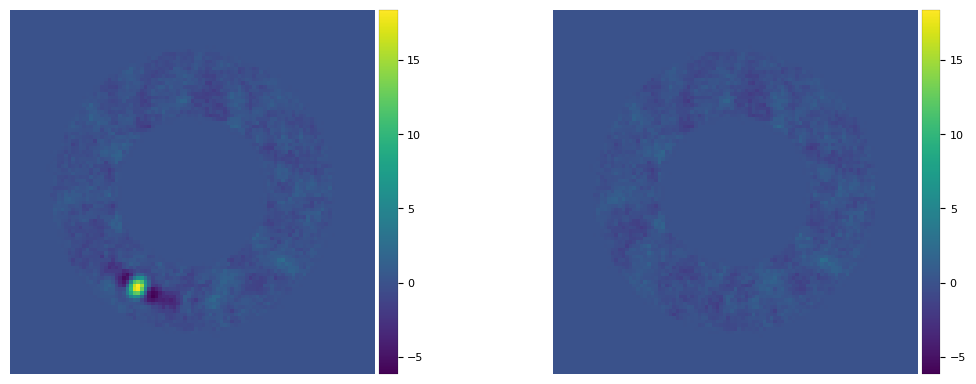

In [36]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)
final_ann_5 = vip.pca.pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp5 = vip.pca.pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

[(30.28526885690995, 240.00920757501143, 428.2727206465928)]


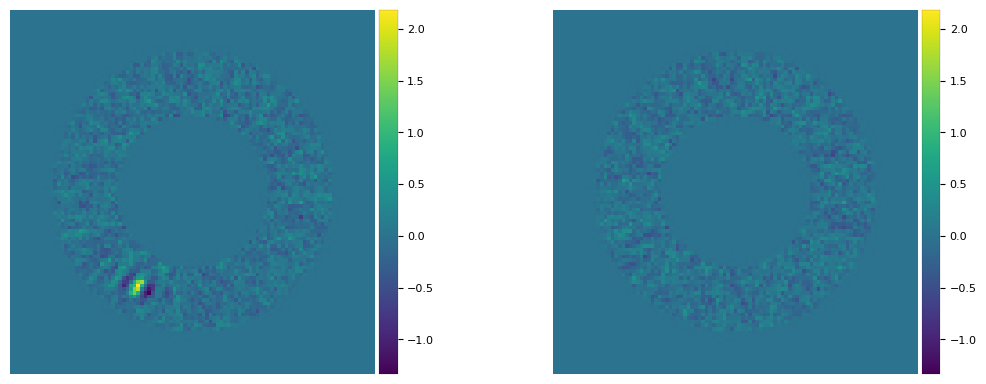

In [37]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)
final_ann_25 = vip.pca.pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp25 = vip.pca.pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

[Go to the top](#Table-of-contents)

## 4.3. NEGFC technique coupled with MCMC

### 4.3.1. Running the MCMC sampler

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can infer both the most likely parameter values and uncertainties on each parameter. 

In [38]:
from vip_hci.negfc import mcmc_negfc_sampling

In NEGFC, PCA in a single annulus is used to speed up the algorithm. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 7](#7.-Generating-synthetic-planets). `annulus_width` is the width of the annulus on which PCA is performed (in pixels), and `aperture_radius` is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [39]:
ncomp_fc = opt_npc_ann

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$. Note that the MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, contrary to `xy_planet` in `firstguess`).

In [40]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a very CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel. At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [41]:
nwalkers, itermin, itermax = (100, 200, 500)


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`.

In [42]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:
- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that the results can be saved by setting `save=False` and providing a path to `output_dir`:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-24 22:26:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		30.61525			15277.00950
1		31.07171			15473.71357
2		30.86180			15338.31510
3		31.47879			15613.47786
4		30.97561			15332.92794
5		31.25589			15440.41164
6		32.40317			15974.76429
7		31.25922			15379.53476
8		32.35025			15883.97177
9		35.43682			17364.04229
10		33.79676			16526.61613
11		30.72285			14992.75178
12		33.16462			16151.17140
13		34.47578			16755.22714
14		32.08478			15561.11879
15		32.57225			15764.96997
16		31.20361			15071.34218
17		36.49095			17588.63935
18		35.59929			17123.25993
19		33

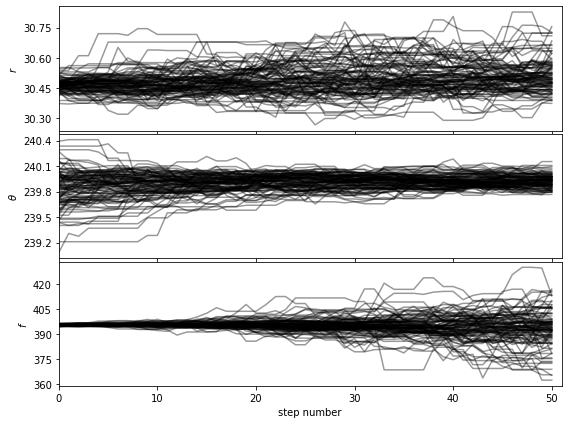

51		33.83483			15158.00160
52		32.57933			14562.95962
53		36.68180			16360.08458
54		32.08050			14275.82339
55		33.36386			14813.55428
56		35.57507			15759.75645
57		35.88652			15861.84184
58		32.05065			14134.33841
59		31.63227			13918.19704
60		30.97542			13598.20938
61		30.96808			13564.01992
62		45.17075			19739.61775
63		40.79533			17786.76344
64		33.60328			14617.42898
65		33.35486			14476.01011
66		32.16780			13928.65567
67		31.54471			13627.31558
68		31.50499			13578.64897
69		32.19122			13842.22331
70		40.05157			17182.12353
71		43.29222			18529.06930
72		52.52424			22427.84920
73		37.35759			15914.33462
74		33.42668			14206.34027
75		33.33238			14132.92827
76		33.70559			14257.46499
77		33.35368			14075.25465
78		33.19956			13977.01560
79		34.69281			14570.98020
80		32.83367			13757.30899
81		33.37426			13950.44235
82		32.87958			13710.78694
83		33.75433			14041.80003
84		33.52359			13912.28944
85		33.82815			14004.85369
86		33.92217			14009.85745
87		33.15527			13659.97042
8

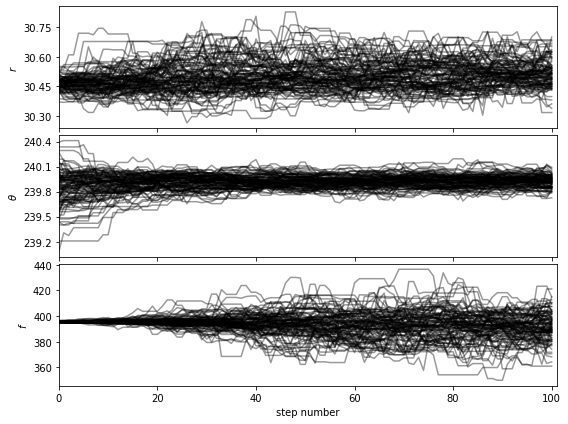

101		37.01295			14731.15609
102		39.61141			15725.73136
103		35.16223			13924.24229
104		35.30962			13947.30069
105		48.47589			19099.50184
106		32.48656			12767.21612
107		36.56686			14334.20794
108		33.64438			13154.95258
109		31.11918			12136.48098
110		31.68872			12326.91364
111		35.21269			13662.52566
112		47.79744			18497.61005
113		39.64004			15301.05698
114		34.16376			13153.04876
115		31.78005			12203.53882
116		31.59362			12100.35608
117		31.90011			12185.84355
118		36.44140			13884.17302
119		33.19260			12613.18724
120		34.18082			12954.53040
121		41.74779			15780.66538
122		31.59526			11911.41340
123		37.19616			13985.75503
124		38.77199			14539.49438
125		35.97900			13456.14525
126		35.26854			13155.16542
127		34.75560			12929.08432
128		32.93937			12220.50553
129		33.51581			12400.84785
130		34.04237			12561.63638
131		32.46764			11948.09152
132		48.96676			17970.80019
133		36.33304			13297.89227
134		37.02092			13512.63434
135		38.98875			14191.90318
136		34.25221			1243

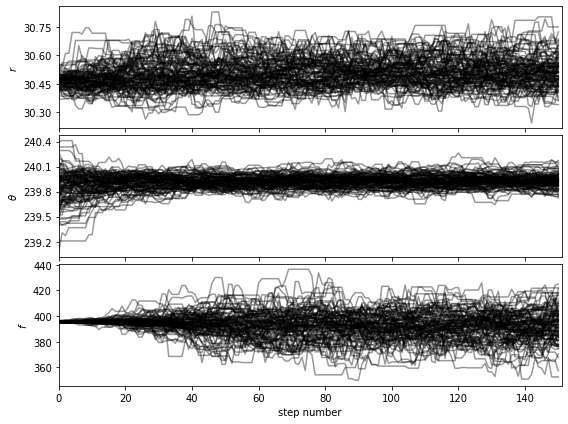

151		34.17833			11894.05884
152		34.28081			11895.44246
153		34.32054			11874.90719
154		34.06070			11750.94219
155		32.72127			11256.11860
156		33.94345			11642.60198
157		34.40871			11767.77779
158		35.03350			11946.42316
159		49.75751			16917.55408
160		36.16111			12258.61493
161		35.62555			12041.43658
162		39.04852			13159.35158
163		32.82758			11030.06822
164		31.55078			10569.51164
165		30.65568			10238.99779
166		31.64819			10538.84561
167		31.23861			10371.21852
168		31.36297			10381.14175
169		31.05276			10247.40948
170		31.75365			10446.95085
171		31.02110			10174.92014
172		31.17809			10195.23412
173		32.01165			10435.79692
174		30.96180			10062.58500
175		31.13488			10087.70015
176		31.19909			10077.30542
177		31.62403			10182.93798
178		30.72531			9862.82611
179		31.65784			10130.50976
180		31.12102			9927.60570
181		31.73558			10091.91508
182		32.72350			10373.34823
183		33.70866			10651.93688
184		32.47385			10229.26181
185		35.20289			11053.70872
186		41.66092			13039.

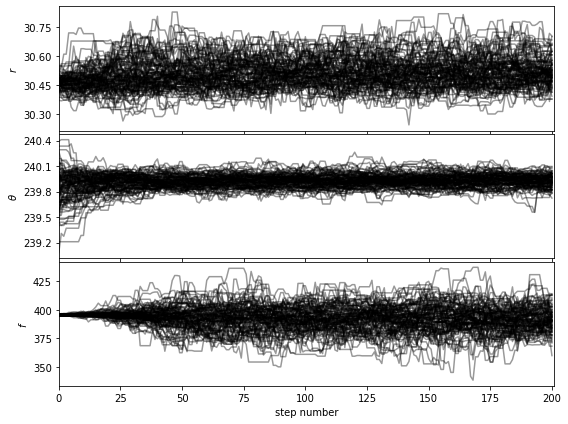

Auto-corr tau/N = [0.07172929 0.0694353  0.06873569]
tau/N <= 0.02 = [False False False] 

201		43.49832			12962.49906
202		41.77741			12407.89047
203		40.24494			11912.50283
204		38.22990			11277.82021
205		39.31062			11557.32287
206		37.62416			11023.88034
207		41.61999			12153.03591
208		37.78984			10996.84286
209		40.65754			11790.68718
210		36.28083			10485.15958
211		36.26716			10444.94323
212		35.67952			10240.02195
213		32.63491			9333.58312
214		38.48889			10969.33394
215		34.55636			9814.00539
216		38.11170			10785.61053
217		34.26640			9663.12621
218		32.77208			9208.95364
219		40.85444			11439.24348
220		40.31299			11247.32449
221		35.67859			9918.64774
222		34.65344			9599.00316
223		34.60021			9549.65796
224		41.50340			11413.43610
225		49.25569			13496.05824
226		41.58400			11352.43118
227		44.84204			12197.03624
228		38.41131			10409.46528
229		42.33695			11430.97731
230		35.97710			9677.83909
231		40.08343			10742.35924
232		42.03466			11223.25315
233		39.08737			10397

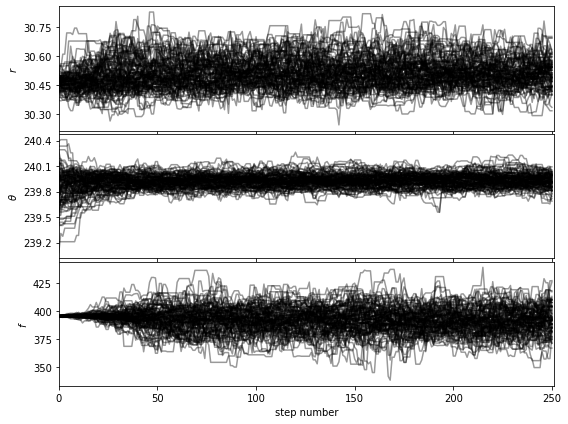

Auto-corr tau/N = [0.06431313 0.06526347 0.06314705]
tau/N <= 0.02 = [False False False] 

251		37.83555			9383.21590
252		36.03549			8900.76480
253		36.17122			8898.12061
254		35.43390			8681.30452
255		32.65058			7966.74250
256		43.17709			10492.03238
257		38.78816			9386.73520
258		37.00138			8917.33186
259		34.12416			8189.79912
260		34.35205			8210.13971
261		39.25561			9342.83637
262		33.78010			8005.88299
263		35.09246			8281.82150
264		36.53194			8585.00684
265		34.90773			8168.40788
266		34.22673			7974.82693
267		32.89949			7632.68122
268		34.35955			7937.05651
269		31.88950			7334.58385
270		36.85236			8439.19159
271		35.83619			8170.65086
272		32.94794			7479.18329
273		33.41447			7551.66977
274		33.71136			7585.05578
275		32.28491			7231.82006
276		35.56498			7930.99009
277		33.56496			7451.42156
278		33.02025			7297.47569
279		35.20899			7745.97736
280		32.50441			7118.46623
281		33.11578			7219.24048
282		33.16078			7195.88839
283		33.81811			7304.71154
284		41.84362			8

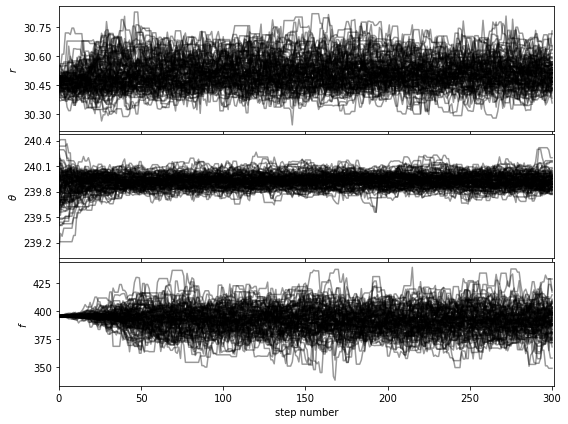

Auto-corr tau/N = [0.06058145 0.06020841 0.05746853]
tau/N <= 0.02 = [False False False] 

301		46.09852			9127.50716
302		40.65779			8009.58443
303		32.46147			6362.44890
304		33.72593			6576.55616
305		47.09699			9136.81684
306		36.82147			7106.54352
307		36.13623			6938.15635
308		39.36235			7518.20885
309		38.02264			7224.30065
310		45.09407			8522.77847
311		42.05971			7907.22642
312		33.47825			6260.43256
313		34.07209			6337.40893
314		35.59733			6585.50605
315		34.90176			6421.92439
316		45.98289			8414.86905
317		45.50359			8281.65429
318		38.46779			6962.66945
319		35.54472			6398.04924
320		34.68481			6208.58135
321		42.17049			7506.34722
322		36.36616			6436.80997
323		37.59853			6617.34075
324		36.44177			6377.30940
325		34.04670			5924.12650
326		37.56032			6497.93571
327		36.45797			6270.77118
328		35.31047			6038.09071
329		32.97025			5604.94199
330		36.13589			6106.96541
331		35.19319			5912.45609
332		43.44117			7254.67539
333		35.68802			5924.21115
334		35.38007			58

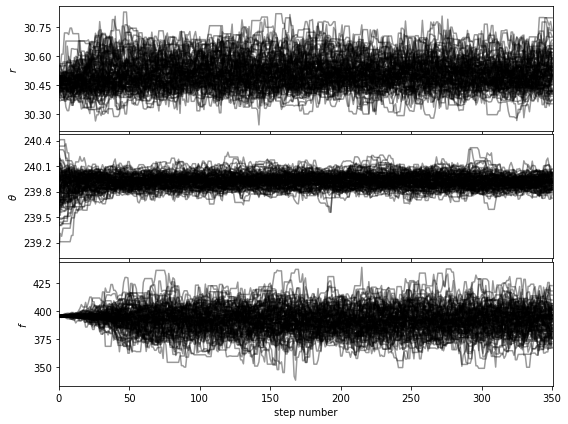

Auto-corr tau/N = [0.05621237 0.0530707  0.05131929]
tau/N <= 0.02 = [False False False] 

351		38.45936			5691.98469
352		35.39682			5203.33225
353		40.74652			5948.99192
354		36.43319			5282.81183
355		34.02541			4899.65933
356		36.99017			5289.59374
357		35.07900			4981.21814
358		33.04479			4659.31511
359		39.93337			5590.67222
360		33.33671			4633.80311
361		40.60765			5603.85611
362		36.02044			4934.79973
363		33.75780			4591.06066
364		33.91312			4578.27147
365		38.97055			5222.05410
366		41.63263			5537.13939
367		43.72013			5771.05742
368		34.49732			4519.14957
369		32.05109			4166.64170
370		33.66025			4342.17289
371		35.47066			4540.24435
372		34.29238			4355.13226
373		35.59907			4485.48282
374		33.99877			4249.84650
375		33.18484			4114.91991
376		33.82043			4159.91264
377		33.80707			4124.46193
378		34.59392			4185.86396
379		34.58087			4149.70392
380		34.00875			4047.04089
381		33.62147			3967.33381
382		33.15026			3878.58065
383		33.05899			3834.84307
384		34.46431			39

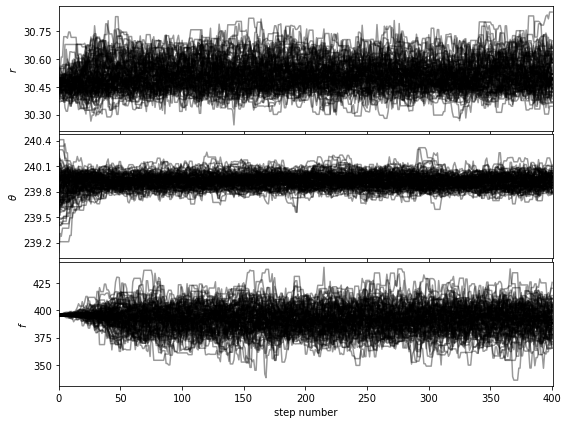

Auto-corr tau/N = [0.0549573  0.04975289 0.04628536]
tau/N <= 0.02 = [False False False] 

401		38.80100			3802.49820
402		35.91578			3483.83095
403		37.44650			3594.86410
404		36.73122			3489.46562
405		42.61464			4005.77625
406		44.53544			4141.79611
407		39.67245			3649.86586
408		44.08502			4011.73664
409		46.10309			4149.27810
410		35.39365			3150.03449
411		33.13668			2916.02758
412		35.15422			3058.41705
413		36.74166			3159.78233
414		35.41833			3010.55839
415		38.60230			3242.59337
416		36.45686			3025.91971
417		35.26120			2891.41815
418		38.95506			3155.35994
419		44.89190			3591.35200
420		36.80768			2907.80640
421		36.09342			2815.28668
422		38.72429			2981.77041
423		38.25987			2907.75020
424		41.06940			3080.20500
425		36.13675			2674.11972
426		36.07109			2633.18979
427		34.73811			2501.14399
428		39.86894			2830.69453
429		36.31920			2542.34414
430		38.04642			2625.20312
431		47.61403			3237.75397
432		34.76055			2328.95651
433		33.32211			2199.25933
434		34.78067			22

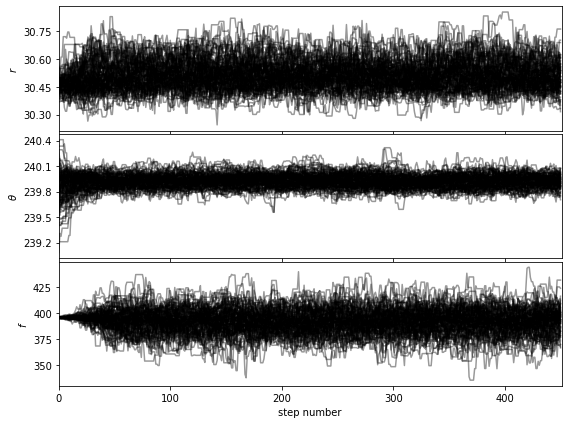

Auto-corr tau/N = [0.05024354 0.04756645 0.04202603]
tau/N <= 0.02 = [False False False] 

451		32.30249			1550.51971
452		31.14500			1463.81486
453		31.45934			1447.12959
454		32.38128			1457.15746
455		37.08139			1631.58116
456		47.07429			2024.19426
457		43.73986			1837.07420
458		51.83461			2125.21922
459		66.58474			2663.38956
460		52.13959			2033.44409
461		49.81357			1892.91562
462		43.07346			1593.71787
463		41.41139			1490.81015
464		46.25566			1618.94817
465		46.99688			1597.89389
466		49.54375			1634.94362
467		48.68854			1558.03312
468		42.17031			1307.27958
469		43.86093			1315.82796
470		43.66203			1266.19887
471		42.97173			1203.20833
472		46.67895			1260.33176
473		42.34504			1100.97091
474		31.98973			799.74327
475		31.77646			762.63497
476		32.80539			754.52399
477		41.44214			911.72697
478		38.69750			812.64742
479		32.19317			643.86350
480		40.94426			777.94092
481		35.32823			635.90807
482		37.18188			632.09191
483		35.99951			575.99211
484		32.35768			485.36523
48

In [43]:
chain = mcmc_negfc_sampling(cubefc, angs, psfn, ncomp=ncomp_fc, plsc=pxscale_naco, scaling=None, 
                            fwhm=fwhm_naco, svd_mode='lapack', annulus_width=4*fwhm_naco, aperture_radius=2, 
                            imlib=imlib_rot, interpolation=interpolation, initial_state=initial_state, 
                            nwalkers=nwalkers, niteration_min=itermin, niteration_limit=itermax, 
                            conv_test=conv_test, ac_c=ac_c, ac_count_thr=ac_count_thr, 
                            check_maxgap=check_maxgap, #rhat_count_threshold=1,
                            bounds=None, nproc=2, display=True, verbosity=2, save=False)

Let's pickle the result to not have to re-run the previous box. For that, adapt the `output_dir` path in the following box before running it:

In [44]:
import pickle
from os.path import isfile
output_dir = "/Users/Valentin/Documents/"
output_file = 'MCMC_results_chain'
overwrite=False # whether to pickle the chain even if it already exists

if not isfile(output_dir+output_file) or overwrite:
    try:
        output = {'chain':chain}
        with open(output_dir+output_file, 'wb') as fileSave:
            pickle.dump(output, fileSave)
    except:
        print("First run the MCMC, and double-check that output_dir exists")

Note that an alternative to the box above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results including additional keys - apart from 'chain', it will also save: 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

Pickled results can be loaded from disk like this:

In [45]:
try:
    if os.path.isfile(output_dir+output_file):
        with open(output_dir+output_file,'rb') as fi:
            myPickler = pickle.Unpickler(fi)
            mcmc_result = myPickler.load()

        print(mcmc_result.keys())

        chain = mcmc_result['chain']
except:
    print("First run the MCMC and pickle the results")

dict_keys(['chain'])


The most accurate approach would involve setting a large enough max. number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

### 4.3.2. Visualizing the MCMC chain: corner plots and walk plots 

In [46]:
from vip_hci.negfc import show_corner_plot, show_walk_plot

Let's first check that the walk plots look ok:

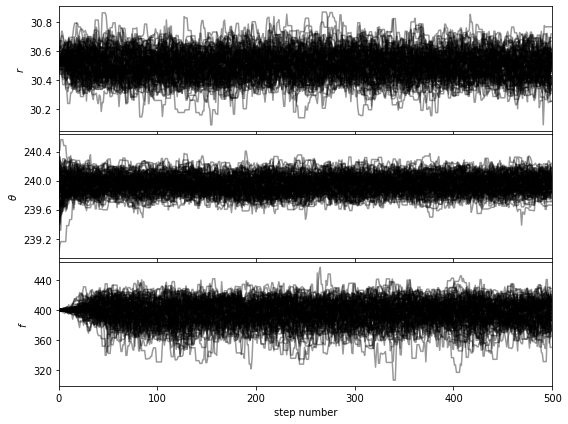

In [47]:
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first third of the chain, to calculate the corner plots:

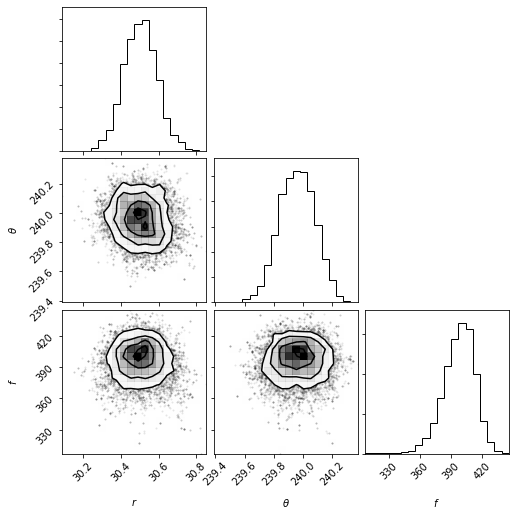

In [48]:
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

### 4.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's flatten the chains:

percentage for r: 68.55840455840459%
percentage for $\theta$: 69.32763532763532%
percentage for flux: 69.07977207977207%


Confidence intervals:
r: 30.515049489278038 [-0.09720299364152751,0.08942675415020673]
theta: 239.93216910729967 [-0.11712688580408326,0.14768172557907633]
flux: 399.0462172097063 [-15.701624710134695,15.701624710134695]

Gaussian fit results:
r: 30.507556263919955 +-0.09048759039470657
theta: 239.95116977292759 +-0.12332175036057297
f: 396.93605282644796 +-15.367432539141346


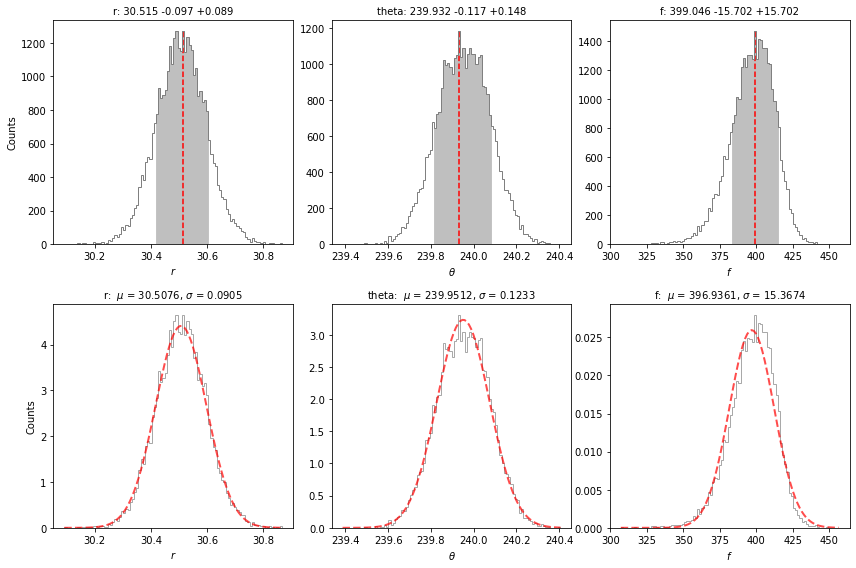

In [49]:
from vip_hci.negfc import confidence

isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False,
                           verbose=False, save=False, title=True)
plt.close()
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, 
                       verbose=True, save=False, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case, these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). It is left as exercise to show that for different $n_{\rm pc}$ values close to the optimal one, the confidence intervals do not necessarily encompass the ground truth values used for injection. So far, only the uncertainty associated to *photon noise* is reflected in the MCMC result (this is a direct consequence of the expression provided for $\chi^2$). As we'll see in the next section, another source of statistical uncertainty has to be taken into account, which will increase the final statistical uncertainties.

[Go to the top](#Table-of-contents)

## 4.4. Residual speckle uncertainty

Residual speckle noise can still bias the best parameter estimates found for the companion.
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with `vip.negfc.speckle_noise_uncertainty` (see also Sec. 3.3 in Wertz et al. 2017 for more details).

In [50]:
pl_par = (val_max['r'],val_max['theta'],val_max['f']) #(30.466232592720647, 239.97149215920115, 399.76518693157954)
pl_par

(30.515049489278038, 239.93216910729967, 399.0462172097063)


#######################################################
###            SPECKLE NOISE DETERMINATION          ###
#######################################################

Number of steps: 360

Process is running for angle: 0.00
Process is running for angle: 45.00
Process is running for angle: 46.00
Process is running for angle: 1.00
Process is running for angle: 47.00
Process is running for angle: 2.00
Process is running for angle: 48.00
Process is running for angle: 3.00
Process is running for angle: 49.00
Process is running for angle: 4.00
Process is running for angle: 50.00
Process is running for angle: 5.00
Process is running for angle: 51.00
Process is running for angle: 6.00
Process is running for angle: 52.00
Process is running for angle: 7.00
Process is running for angle: 53.00
Process is running for angle: 8.00
Process is running for angle: 54.00
Process is running for angle: 9.00
Process is running for angle: 55.00
Process is running for angle: 10.00
Process is running for ang

percentage for $\theta$: 68.33333333333333%
percentage for flux: 70.83333333333331%


Confidence intervals:
r: -0.03539492603638105 [-0.03720419722852509,0.14468298922204198]
theta: 0.02428947160383884 [-0.1160107206298141,0.06246731110836138]
flux: -5.575231677771536 [-6.094192785665226,18.282578356995668]

Gaussian fit results:
r: -0.0013488273209354812 +-0.05923183391659522
theta: 0.0020151203271627552 +-0.07990492432427708
f: -0.25564936823295265 +-11.463922479517661


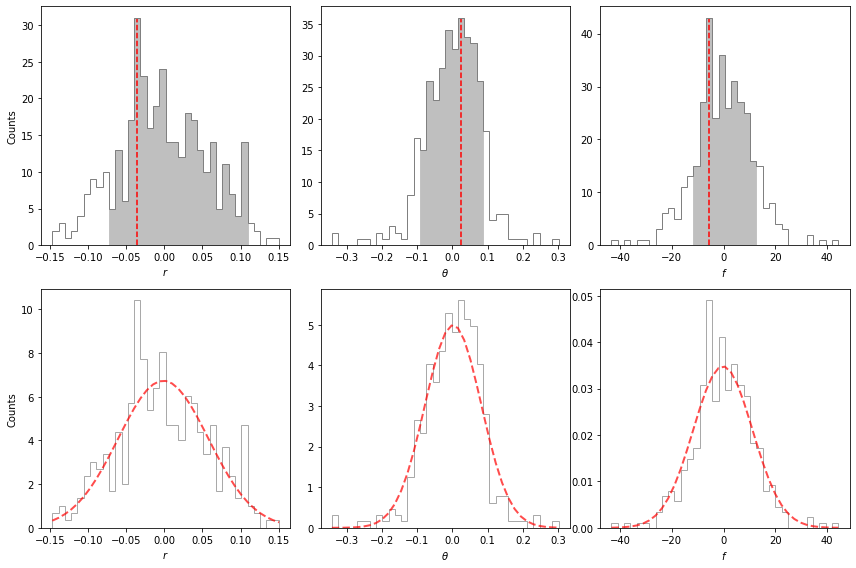

In [51]:
from vip_hci.negfc import speckle_noise_uncertainty
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, vip.pca.pca_annulus, 
                                        psfn, pxscale_naco, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options={'ncomp':ncomp_fc, 'annulus_width':4*fwhm_naco}, 
                                        transmission=None, mu_sigma=None, wedge=None, weights=None, force_rPA=False, 
                                        nproc=2, simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

In [52]:
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [53]:
sp_unc

array([ 0.05923183,  0.07990492, 11.46392248])

For comparison, the uncertainties associated to photon noise found by the MCMC procedure were:

In [54]:
sigma

array([ 0.09048759,  0.12332175, 15.36743254])

The statistical uncertainties on the parameters of the test companion are therefore:

In [55]:
stat_unc = np.sqrt(np.power(sigma,2)+np.power(sp_unc,2))
stat_unc

array([ 0.10814996,  0.14694574, 19.17236296])

In [56]:
msg = "The inferred parameters of the test companion, including statistical uncertainties are thus: "
msg += " r={:.2f}+-{:.2f} px, PA={:.2f}+-{:.2f}deg and flux={:.2f}+-{:.2f} ADUs"
print(msg.format(val_max['r'],stat_unc[0],val_max['theta'],stat_unc[1],val_max['f'],stat_unc[2]))

The inferred parameters of the test companion, including statistical uncertainties are thus:  r=30.52+-0.11 px, PA=239.93+-0.15deg and flux=399.05+-19.17 ADUs


[Go to the top](#Table-of-contents)

## 4.5. Final uncertainties

The final uncertainties on the planet parameters should include both *statistical* and *systematic* uncertainties. 
The latter include both the photon noise and residual speckle noise uncertainties discussed above. 
Systematic uncertainties include both the uncertainty on the star location (with respect to the center of the AGPM), affecting and instrumental calibration errors such as:
- the uncertainty on the star location (with respect to the center of the AGPM);
- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images. Given the shift plots in [Sec. 2.1](#2.1.-Re-centering-the-ADI-frames), it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [57]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px

The latter translates to an uncertainty on $\theta$ of $0.09/r$ (in rad). The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [58]:
star_unc = np.array([cen_unc*pxscale_naco, np.rad2deg(cen_unc/val_max['r']), 0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [59]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # deg
syst_unc = np.array([val_max['r']*dr_unc, tn_unc, 0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [60]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

final_unc = np.sqrt(np.power(sigma,2)+np.power(sp_unc,2)+np.power(star_unc,2)+np.power(syst_unc,2))

In [61]:
msg = "The final uncertainties on the radial separation, PA and flux of the companion are: "
msg+= "dr = {:.2f} mas, dPA = {:.2f}deg and df = {:.2f} ADUs"
print(msg.format(final_unc[0]*1000, final_unc[1], final_unc[2]))

The final uncertainties on the radial separation, PA and flux of the companion are: dr = 3.95 mas, dPA = 0.24deg and df = 19.17 ADUs


[Go to the top](#Table-of-contents)

# 5. Throughput and contrast curve

## 5.1. Algorithmic throughput

`VIP` allows to measure the throughput of its algorithms by injecting fake companions. The throughput gives us an idea of how much the algorithm subtracts or biases the signal from companions, as a function of the distance from the center (high throughput = low amount of self-subtraction). Let's assess it for our toy datacube. The relevant function is `vip.metrics.throughput`.

First, let's create a cube without the real companion (beta Pic b) - the parameters hardcoded below were inferred separately in the same way as was done for the fake companion in Sec. 8:

In [62]:
cube_emp = cube_planet_free([(16.583, 149.111, 700)], cube, angs, psfn=psfn, plsc=pxscale_naco, 
                            imlib=imlib_rot, interpolation=interpolation)

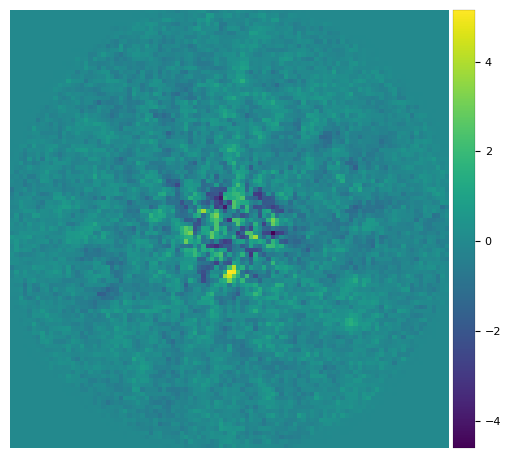

In [63]:
pca_emp = vip.pca.pca(cube_emp, angs, ncomp=11, imlib=imlib_rot, interpolation=interpolation, verbose=False)
plot_frames(pca_emp, axis=False)

In [64]:
res_thr = vip.metrics.throughput(cube_emp, angs, psfn, fwhm_naco, pxscale_naco, ncomp=15, 
                                 algo=vip.pca.pca, nbranch=1, imlib=imlib_rot, 
                                 interpolation=interpolation full_output=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-25 05:34:05
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Cube without fake companions processed with pca
Running time:  0:00:00.127134
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Measured annulus-wise noise in resulting frame
Running time:  0:00:00.175023
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Flux in 1xFWHM aperture: 1.000
Fake companions injected in branch 1 (pattern 1/3)
Running time:  0:00:00.362474
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Cube with fake companions processed with pca
Measuring its annulus-wise throughput
Running time:  0:00:00.484808
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Fake companions injected in branch 1 (pattern 2/3)
Running time:  0:00:00.658117
――――――――――――――――――

Text(0.5, 0, 'separation in pixels')

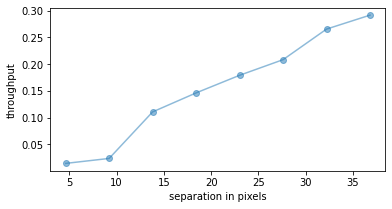

In [65]:
figure(figsize=(6,3))
if version.parse(vvip)>=version.parse('1.0.0'):
    plot(res_thr[3], res_thr[0][0,:], 'o-', alpha=0.5)
else:
    plot(res_thr[2], res_thr[0][0,:], 'o-', alpha=0.5)    
ylabel('throughput')
xlabel('separation in pixels')

<font color=orange> **Question 5.1**: Why does the throughput increase with radial separation?</font>

Let's compare this with the annular PCA result:

In [66]:
res_thr2 = vip.metrics.throughput(cube_emp, angs, psfn, fwhm_naco, pxscale_naco, 
                                  algo=vip.pca.pca_annular, nbranch=1, verbose=False,
                                  full_output=True, ncomp=15, radius_int=int(fwhm_naco), 
                                  delta_rot=0.5, svd_mode='lapack', asize=2,
                                  imlib=imlib_rot, interpolation=interpolation)

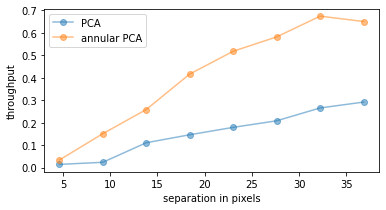

In [67]:
figure(figsize=(6,3))
if version.parse(vvip)>=version.parse('1.0.0'):
    plot(res_thr[3], res_thr[0][0,:], 'o-', label='PCA', alpha=0.5)
    plot(res_thr2[3], res_thr2[0][0,:], 'o-', label='annular PCA', alpha=0.5)
else:
    plot(res_thr[2], res_thr[0][0,:], 'o-', label='PCA', alpha=0.5)
    plot(res_thr2[2], res_thr2[0][0,:], 'o-', label='annular PCA', alpha=0.5)
ylabel('throughput')
xlabel('separation in pixels')
_ = legend(loc='best')

We clearly see the gain in throughput by applying a parallactic angle rejection in our annular PCA processing. For a sequence with more field rotation, the `delta_rot` value could be increased to further increase the throughput.

<font color=green> **Answer 5.1**: For a given parallactic angle threshold (or lack thereof in standard `pca.pca`), there is more linear motion of the field radially outward, resulting in less self-subtraction of any putative planet. </font>

[Go to the top](#Table-of-contents)

## 5.2. Contrast curve generation for ADI

Now let's see how to generate 5-sigma contrast curves for ADI data using `vip.metrics.contrast_curve`. 
The contrast curve shows the achieved contrast (i.e. how much fainter than the star a companion can be detected) as a function of radius, for a given datacube post-processed with a given algorithm.

The contrast curve takes into account both the noise level in the final image and the algorithmic throughput. The noise level is used to infer the signal required for the S/N to achieve a 5-sigma significance at each radial separation, as calculated in [Section 4.2](#4.2.-Significance). Note that `sigma` is an input parameter such that the contrast curve can also be calculated for e.g. 1 or 3 $\sigma$.

Among other parameters of the `contrast_curve` function, ``algo`` takes any function in ``VIP`` for model PSF subtraction, and optional parameters of the `algo` can also be passed as regular parameters of `contrast_curve`. Parameter `starphot` sets the flux of the star. The latter was obtained from the non-coronagraphic PSF before normalization:

In [68]:
starphot = 764939.6

In the example below, we'll first calculate the contrast curve obtained with full-frame PCA, and then with PCA in concentric annuli with a PA threshold.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-25 05:34:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 4.603450563658683, # BRANCHES = 1, SIGMA = 5, STARPHOT = 764939.6
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:00.998005
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


/Users/Valentin/anaconda2/envs/vipenv/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)


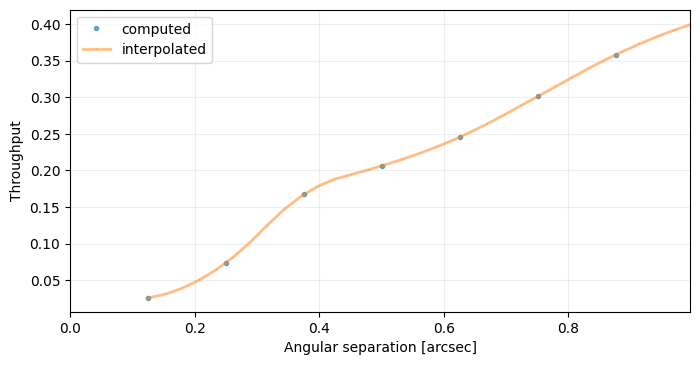

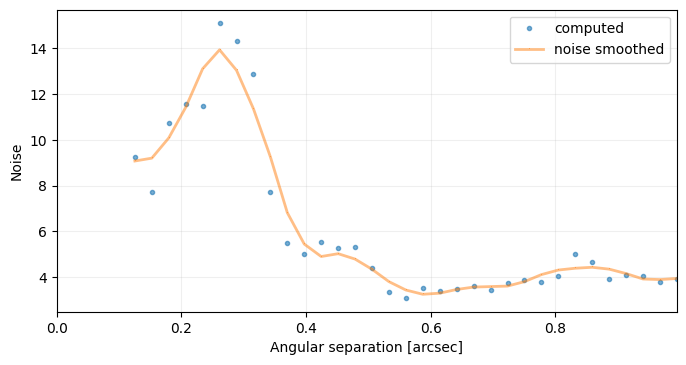

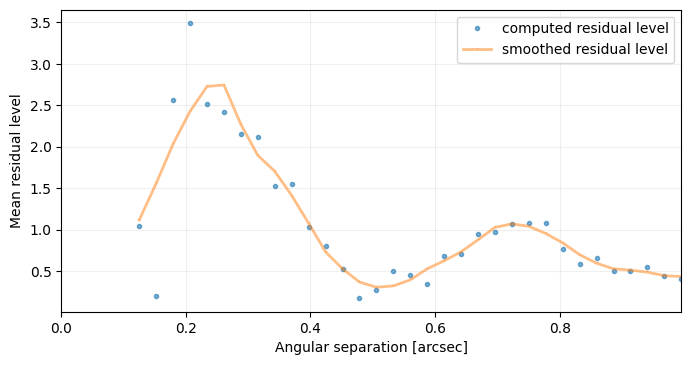

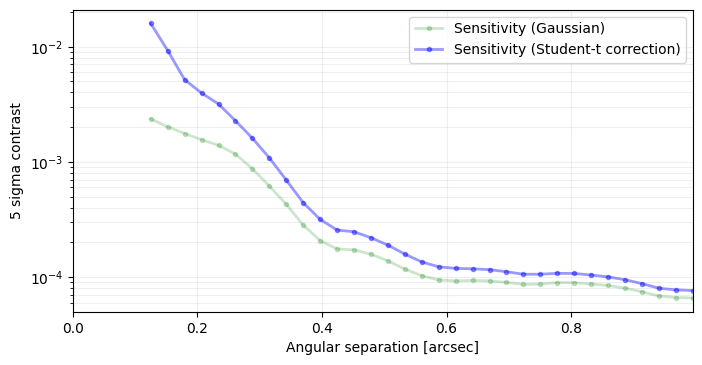

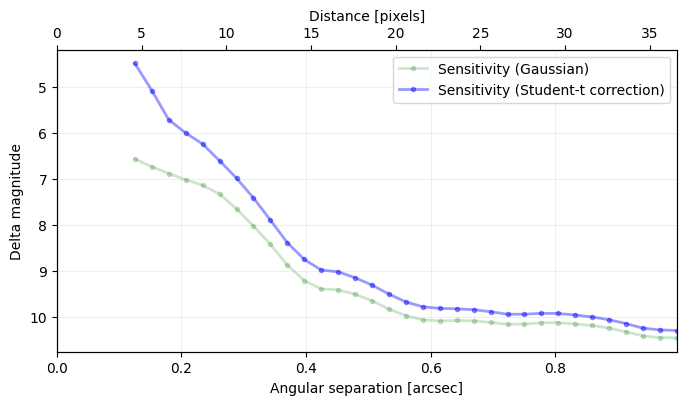

In [69]:
_ = vip.metrics.contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                               sigma=5, nbranch=1, algo=vip.pca.pca, ncomp=11,
                               imlib=imlib_rot, interpolation=interpolation, debug=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-25 05:34:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca_annular, FWHM = 4.603450563658683, # BRANCHES = 1, SIGMA = 5, STARPHOT = 764939.6
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:06.151565
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


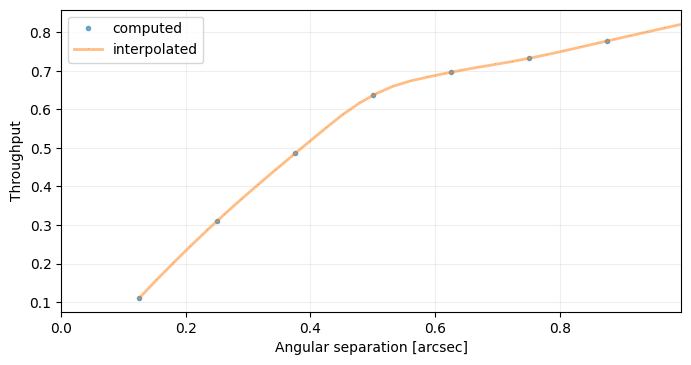

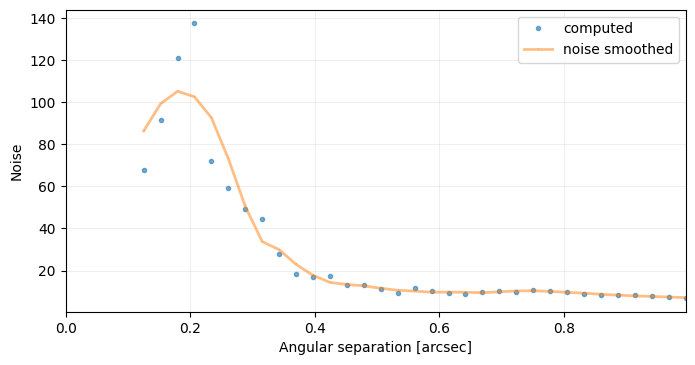

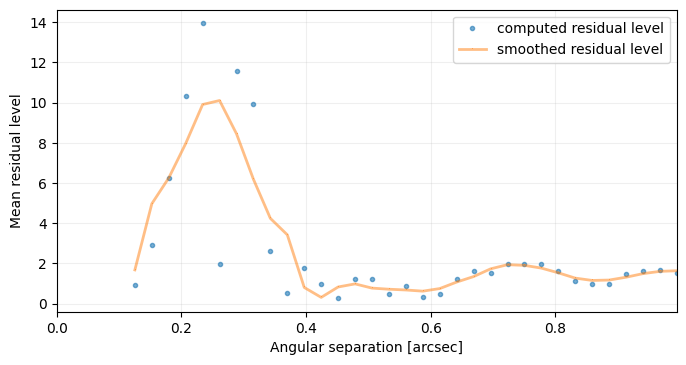

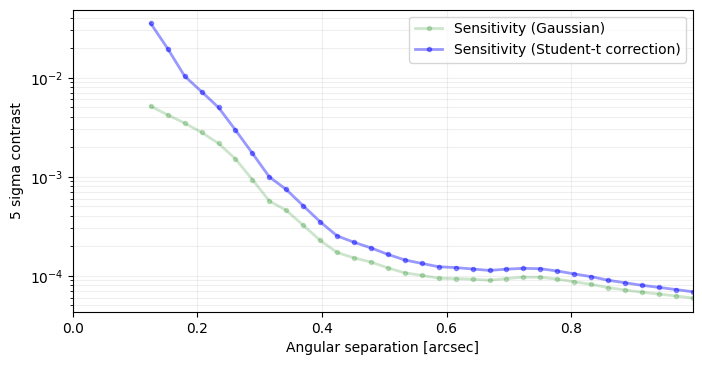

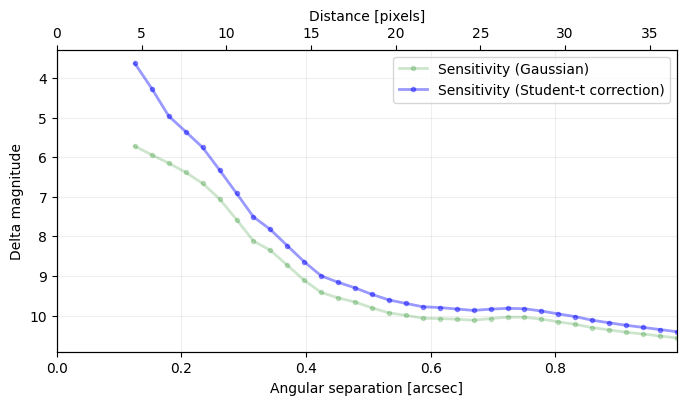

In [70]:
_ = vip.metrics.contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                               sigma=5, nbranch=1, delta_rot=0.5, algo=vip.pca.pca_annular, ncomp=8, 
                               radius_int=int(fwhm_naco), imlib=imlib_rot, interpolation=interpolation,
                               debug=True)

<font color=orange> **Question 5.2**: Given the hard encoded planet parameters and stellar flux above, where would Beta Pic b sit in this contrast curve?</font>

<font color=orange> **Question 5.3**: If a companion is present in the datacube, how do you expect it to affect the contrast curve? In other words what would happen if `cube` was provided to `contrast_curve` instead of `cube_emp`? </font>

<font color=green> **Answer 5.2**:  Not removing authentic companions from the cube before calculating the contrast curve will lead to a bump in the contrast curve (i.e. an underestimation of the contrast performance) at the radial separation of the companion. This is because the point source and surrounding negative side lobes will contribute to increase the estimated noise (i.e. it will increase the standard deviation of fluxes measured in apertures at that radius - cfr. definition of S/N ratio). </font>

<font color=green> **Answer 5.3**:  Not removing authentic companions from the cube before calculating the contrast curve will lead to a bump in the contrast curve (i.e. an underestimation of the contrast performance) at the radial separation of the companion. This is because the point source and surrounding negative side lobes will contribute to increase the estimated noise (i.e. it will increase the standard deviation of fluxes measured in apertures at that radius - cfr. definition of S/N ratio). </font>

[Go to the top](#Table-of-contents)